In [689]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from scipy.stats import spearmanr


In [690]:
# ===============================================================
# COACH CHANGE PREDICTION — DATA PREPARATION
# ===============================================================

# Load Data
coaches = pd.read_csv("data/coaches.csv")
teams = pd.read_csv("data/teams.csv")
awards_players = pd.read_csv("data/awards_players.csv")

# Add info about next year's coach (target variable)
coaches["next_coachID"] = coaches.groupby("tmID")["coachID"].shift(-1)
coaches["coach_changed_next_year"] = (coaches["coachID"] != coaches["next_coachID"]).astype(int)


# Compute win ratio
coaches["win_ratio"] = np.where(
    (coaches["post_wins"] == 0) & (coaches["post_losses"] == 0),
    coaches["won"] / (coaches["won"] + coaches["lost"]),
    (coaches["won"] + coaches["post_wins"]) /
    (coaches["won"] + coaches["lost"] + coaches["post_wins"] + coaches["post_losses"])
)

# Ensure correct order before applying cumulative stats
coaches = coaches.sort_values(["coachID", "year"]).reset_index(drop=True)


# Compute Cumulative Win Ratio
def compute_cumulative_win_ratio(group):
    group = group.copy()
    group["cumulative_win_ratio"] = 0.0
    for i in range(len(group)):
        if i == 0:
            group.loc[group.index[i], "cumulative_win_ratio"] = group.loc[group.index[i], "win_ratio"]
        else:
            prev = group.loc[group.index[i - 1], "cumulative_win_ratio"]
            curr = group.loc[group.index[i], "win_ratio"]
            # simple weighted smoothing (50/50)
            group.loc[group.index[i], "cumulative_win_ratio"] = 0.5 * curr + 0.5 * prev
    # shift so each season uses only past cumulative performance
    group["cumulative_win_ratio"] = group["cumulative_win_ratio"].shift(1)
    return group

# Apply per coach
coaches = coaches.groupby("coachID", group_keys=False).apply(compute_cumulative_win_ratio)

# Fill NaNs for rookie coaches (no prior data)
avg_cumulative_win_ratio = coaches["cumulative_win_ratio"].mean(skipna=True)
coaches["cumulative_win_ratio"] = coaches["cumulative_win_ratio"].fillna(avg_cumulative_win_ratio)


# Sort by team and year first
coaches = coaches.sort_values(["tmID", "year"]).reset_index(drop=True)

# Compute team win ratio
coaches["team_win_ratio"] = np.where(
    (coaches["post_wins"] == 0) & (coaches["post_losses"] == 0),
    coaches["won"] / (coaches["won"] + coaches["lost"]),
    (coaches["won"] + coaches["post_wins"]) /
    (coaches["won"] + coaches["lost"] + coaches["post_wins"] + coaches["post_losses"])
)

# 3-year rolling average on past seasons
coaches["3yr_win_ratio"] = (
    coaches.groupby("tmID")["team_win_ratio"]
    .shift(1)  # use only past seasons
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

average_3yr_team_win_ratio = coaches["3yr_win_ratio"].mean(skipna=True)
coaches["3yr_win_ratio"] = coaches["3yr_win_ratio"].fillna(average_3yr_team_win_ratio)


# Expectation gap (current vs. recent average)
coaches["expectation_gap"] = coaches["cumulative_win_ratio"] - coaches["3yr_win_ratio"]



# Filter only Coach of the Year awards
coach_awards = awards_players[awards_players["award"] == "Coach of the Year"].copy()
coach_awards = coach_awards.rename(columns={"playerID": "coachID", "year": "award_year"})

# Merge award info into coaches (many-to-many, one row per award)
coaches_awards = coaches.merge(
    coach_awards[["coachID", "award_year"]],
    on="coachID",
    how="left"
)

# Only keep awards up to and including that season
coaches_awards["award_up_to_season"] = (
    coaches_awards["award_year"] <= coaches_awards["year"]
).astype(int)

# Group by coach and season, sum awards
coach_award_count = (
    coaches_awards.groupby(["coachID", "year"])["award_up_to_season"]
    .sum()
    .reset_index()
    .rename(columns={"award_up_to_season": "coach_award_count"})
)

# Merge back into the original coaches dataframe
coaches = coaches.merge(coach_award_count, on=["coachID", "year"], how="left")

# Fill NaNs for coaches with no awards
coaches["coach_award_count"] = coaches["coach_award_count"].fillna(0).astype(int)




# Team stability index (how often the team fires coaches)
coaches["team_stability_index"] = (
    coaches.groupby("tmID")["coach_changed_next_year"]
    .shift(1)  # only use previous seasons
    .rolling(3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)


# Years with team (coach tenure)
coaches = coaches.sort_values(["coachID", "tmID", "stint", "year"])
coaches["years_with_team_stint"] = (
    coaches.groupby(["coachID", "tmID", "stint"]).cumcount() + 1
)

#'''
# merge teams info into coaches so each coach row has that season's team info
coaches = coaches.merge(
    teams[["year", "tmID", "playoff"]],
    on=["year", "tmID"],
    how="left",
    validate="m:1"   
)

coaches = coaches.sort_values(["tmID", "year"]).reset_index(drop=True)

coaches["team_prev_playoff"] = coaches.groupby("tmID")["playoff"].shift(1).map({"Y": 1, "N": 0})


# Playoff miss streak
def playoff_streak(series):
    streaks = []
    streak = 0
    for made in series:
        if made == 0:
            streak += 1
        else:
            streak = 0
        streaks.append(streak)
    return streaks

coaches["playoff_miss_streak"] = coaches.groupby("tmID")["team_prev_playoff"].transform(playoff_streak)

#'''

coaches = coaches.drop(columns=["lgID", "won", "lost", "post_wins", "post_losses", "win_ratio","team_win_ratio", "next_coachID", "playoff", "team_prev_playoff"])

coaches = coaches.sort_values(["tmID", "year"]).reset_index(drop=True)
coaches_year = coaches[coaches["year"] == 10]
coaches_year.head(20)

/tmp/ipykernel_12329/742242641.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coaches = coaches.groupby("coachID", group_keys=False).apply(compute_cumulative_win_ratio)


,coachID,year,tmID,stint,coach_changed_next_year,cumulative_win_ratio,3yr_win_ratio,expectation_gap,coach_award_count,team_stability_index,years_with_team_stint,playoff_miss_streak
1,meadoma99w,10,ATL,0,1,0.117647,0.117647,0.000000,1,0.000000,2,1
13,keyst99wc,10,CHI,0,1,0.352941,0.303922,0.049020,0,0.666667,2,3
24,thibami99w,10,CON,0,1,0.598316,0.617233,-0.018917,2,0.000000,7,0
35,laimbbi01w,10,DET,1,1,0.650009,0.674301,-0.024293,1,0.000000,1,0
36,mahorri01w,10,DET,2,1,0.519859,0.558140,-0.038281,0,0.333333,1,0
55,dunnli99wc,10,IND,0,1,0.430743,0.556607,-0.125863,0,0.333333,2,0
68,coopemi01w,10,LAS,0,1,0.542817,0.520475,0.022342,1,0.333333,7,0
83,gilloje01w,10,MIN,0,1,0.519859,0.385337,0.134522,0,0.666667,1,5
94,coylepa99w,10,NYL,1,1,0.496882,0.444330,0.052553,0,0.000000,1,0
95,donovan99w,10,NYL,2,1,0.505436,0.454134,0.051303,0,0.333333,1,1


Treino: (131, 12) | Teste (9): (15, 12)

Evaluation for year 9:
Accuracy:  0.800
Precision: 0.571
Recall:    1.000
F1-score:  0.727
Spearman: 0.663 (p=0.007)

🏀 Top predicted coach changes (with actual result):
     year     coachID  pred_proba  predicted_change  coach_changed_next_year
160     9  rollitr01w    0.725225                 1                        1
82      9  zierddo99w    0.539900                 1                        1
45      9  thompka99w    0.517536                 1                        1
93      9  coylepa99w    0.477060                 1                        0
0       9  meadoma99w    0.439135                 1                        0
108     9  gaineco01w    0.409447                 1                        0
159     9  kenlaje99w    0.408972                 1                        1
123     9  bouceje01w    0.399012                 0                        0
12      9   keyst99wc    0.366214                 0                        0
143     9  aglerbr9

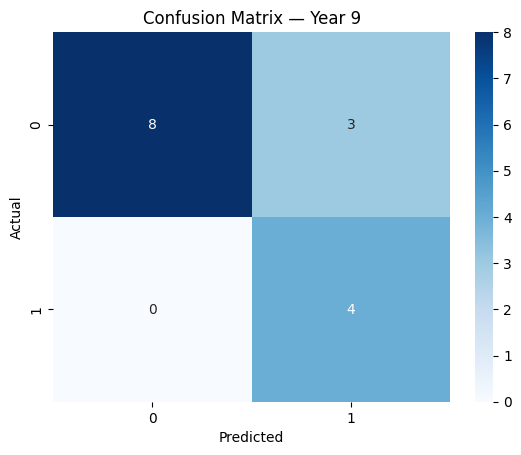

/tmp/ipykernel_12329/4117933284.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")


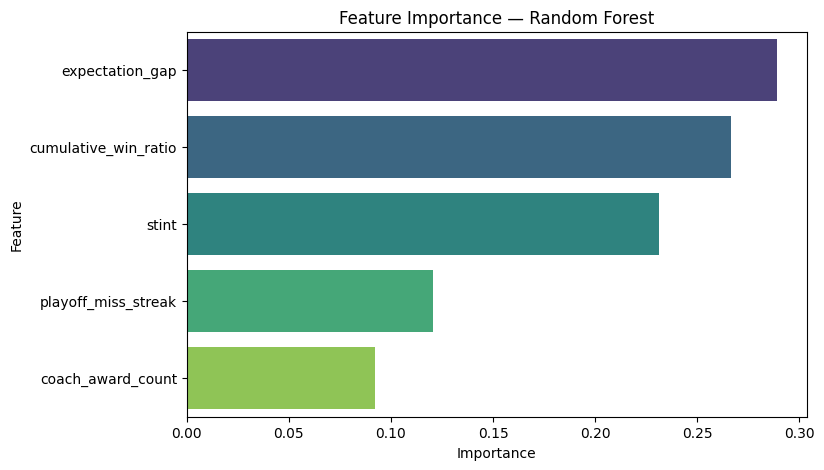


Feature Influence (higher = more impact on firing prediction):
                Feature  Importance
1       expectation_gap    0.289226
0  cumulative_win_ratio    0.266435
3                 stint    0.231506
4   playoff_miss_streak    0.120697
2     coach_award_count    0.092135


In [691]:
# ===============================================================
# COACH CHANGE PREDICTION — MODEL & EVALUATION
# ===============================================================

target_year = 9
train_data = coaches[coaches["year"] < target_year]
test_data  = coaches[coaches["year"] == target_year]

print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")

# Define features and target

features = [
    "cumulative_win_ratio"
    ,"expectation_gap"
    ,"coach_award_count"
    ,"stint"
    #,"years_with_team_stint"  
    #,"team_stability_index"
    ,"playoff_miss_streak"  
]
target = "coach_changed_next_year"

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)


# Predictions

test_data = test_data.copy()
test_data.loc[:, "pred_proba"] = model.predict_proba(X_test)[:, 1]

threshold = 0.4
test_data.loc[:, "predicted_change"] = (test_data["pred_proba"] > threshold).astype(int)


acc = accuracy_score(y_test, test_data["predicted_change"])
prec = precision_score(y_test, test_data["predicted_change"])
rec = recall_score(y_test, test_data["predicted_change"])
f1 = f1_score(y_test, test_data["predicted_change"])
spearman_corr, spearman_p = spearmanr(y_test, test_data["pred_proba"])

print(f"\nEvaluation for year {target_year}:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"Spearman: {spearman_corr:.3f} (p={spearman_p:.3f})")

print("\n🏀 Top predicted coach changes (with actual result):")
print(
    test_data[[
        "year", "coachID", "pred_proba",
        "predicted_change", "coach_changed_next_year"
    ]]
    .sort_values("pred_proba", ascending=False)
    .head(test_data.shape[0])
)

# Evaluation


# Confusion Matrix

# Column [0]: probability of class 0: coach stays

# Column [1]: probability of class 1: coach changes/fired


cm = confusion_matrix(y_test, test_data["predicted_change"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — Year {target_year}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance

importance = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance — Random Forest")
plt.show()

print("\nFeature Influence (higher = more impact on firing prediction):")
print(importance)
